# Projekt 1 - UTA

Autorzy: Mikołaj Nowak 151813, Anna Roszkiewicz 151883

## Informacja preferencyjna

### Definicja problemu

Celem jest uszeregowanie 27 możliwych wariantów utilizacji odpadów radioaktywnych. Każdy z wariantów charakteryzuje się jednym z trzech scenariuszy czasowych (S1, S2, S3), jedną z trzech lokalizacji (R1, R2, R3) oraz jedną z trzech metod finansowania (F1, F2, F3).

Ponadto, każdy wariant został oceniony na czterech kryteriach typu koszt:
- C1: całkowity koszt,
- C2: koszty poniesione przez obecnych konsumentów (przez pierwsze 30 lat),
- C3: koszty poniesione przez przyszłych konsumentów (po upływie 30 lat),
- C4: ryzyko finansowe.

### Polityka firmy

Podczas tworzenia rankingu częściowego będziemy kierować się następującą polityką:

- Wydajność produkcji energii elektrycznej wzrośnie w przyszłości. Dodatkowo nie chcę brać pożyczek. (1)
- Preferowana jest lokalizacja R2 nad R1 oraz R1 nad R3. (4)

Drugi warunek jest łatwy do interpretacji - odnosi się jedynie do lokalizacji składowiska.

Pierwszy warunek odnosi się do czterech kryteriów. Chcemy minimalizować przede wszystkim wartość na kryterium C2. Optymistycznie podchodzimy do przyszłości - jesteśmy w stanie zaakceptować gorsze wartości na kryteriach C3 i C4.

### Pary wariantów referencyjnych

Utworzymy ranking częściowy poprzez porównanie parami następujących wariantów:

- 12 i 19
- 11 i 25
- 1 i 27
- 18 i 27
- 3 i 6

### Wczytanie danych

In [1]:
import pandas

data = pandas.read_csv("Nuclear waste management.csv")
data.columns = ["ID", "C1", "C2", "C3", "C4"]
display(data.style.hide())

ID,C1,C2,C3,C4
1,0.600000,0.930000,0.000000,0.730000
2,0.660000,0.550000,0.450000,0.490000
3,1.000000,0.450000,0.570000,0.500000
4,0.480000,0.870000,0.000000,0.750000
5,0.620000,0.400000,0.560000,0.500000
6,0.780000,0.270000,0.710000,0.500000
7,0.400000,0.900000,0.000000,0.820000
8,0.640000,0.440000,0.540000,0.540000
9,0.650000,0.300000,0.710000,0.550000
10,0.450000,0.860000,0.000000,0.730000


### Porównania parami

- 12 > 19, ponieważ warianty mają taką samą lokalizację (R1), a 12 ma dużo mniejszą wartość na kryterium C2
- 11 > 25, ponieważ preferujemy lokalizację R1 nad R3
- 1 > 27, ponieważ preferujemy lokalizację R1 nad R3, a ponadto 1 ma dużo mniejszą wartość na kryterium C2
- 18 ~ 27, ponieważ oba mają lokalizację R3, a także taką samą wartość na kryterium C2,
- 6 > 3, ponieważ preferujemy lokalizację R2 nad R1, a ponadto 6 ma mniejszą wartość na kryteriach C2 i C1.

## Solver UTA

In [2]:
!pip install pulp
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value, LpStatus

### Definicja problemu

In [63]:
# definicja funkcji celu
prob = LpProblem("UTA", LpMaximize)
e = LpVariable(name="e", lowBound=0, upBound=1)
prob += e

# utworzenie zmiennych decyzyjnych dla kryteriów
criterion_vars = {}
for column in data:
    if column != "ID":
        criterion_vars[column] = {val: LpVariable(f"{column}_{val}", lowBound=0, upBound=1) for val in data[column].values}

# dodanie ograniczeń UTA
sum_max = 0
for column in data:
    if column != "ID":
        values = data[column].values.tolist()

        # monotoniczność
        values.sort()
        for i in range(len(values) - 1):
            prob += criterion_vars[column][values[i]] <= criterion_vars[column][values[i+1]], f"Monotonicity_{column}_{i}"

        # dodatkowe ograniczenie - minimalna waga kryterium 0.1
        min_val = min(values)
        prob += criterion_vars[column][min_val] == 0.1, f"Normalize_{column}_Lowest"

        # normalizacja - suma maksymalnych wartości równa 100
        max_val = max(values)
        sum_max += criterion_vars[column][max_val] 
prob += sum_max == 1, "Normalize_Criteria_Sum"

# utworzenie zmiennych definiujących użyteczność wariantów
utilities = []
utilities.append(0) # warianty są numerowane od 1
for i, variant in data.iterrows():
    u = LpVariable(f"U_{i+1}", lowBound=0)
    utilities.append(u)
    prob += u == lpSum([
        criterion_vars["C1"][variant["C1"]],
        criterion_vars["C2"][variant["C2"]],
        criterion_vars["C3"][variant["C3"]],
        criterion_vars["C4"][variant["C4"]]
    ]), f"Utility_{i+1}"

# dodanie ograniczeń z porównań parami
prob += utilities[12] >= utilities[19] + e, "Prefer_12_over_19"
prob += utilities[11] >= utilities[25] + e, "Prefer_11_over_25"
prob += utilities[1] >= utilities[27] + e, "Prefer_1_over_27"
prob += utilities[18] == utilities[27], "18_equal_27"
prob += utilities[6] >= utilities[3] + e, "Prefer_6_over_3"

In [64]:
prob

UTA:
MAXIMIZE
1*e + 0
SUBJECT TO
Monotonicity_C1_0: C1_0.32 - C1_0.34 <= 0

Monotonicity_C1_1: C1_0.34 - C1_0.35 <= 0

Monotonicity_C1_2: C1_0.35 - C1_0.4 <= 0

Monotonicity_C1_3: C1_0.4 - C1_0.44 <= 0

Monotonicity_C1_4: C1_0.44 - C1_0.45 <= 0

Monotonicity_C1_5: C1_0.45 - C1_0.48 <= 0

Monotonicity_C1_6: 0 C1_0.48 <= 0

Monotonicity_C1_7: C1_0.48 - C1_0.59 <= 0

Monotonicity_C1_8: C1_0.59 - C1_0.6 <= 0

Monotonicity_C1_9: C1_0.6 - C1_0.61 <= 0

Monotonicity_C1_10: C1_0.61 - C1_0.62 <= 0

Monotonicity_C1_11: C1_0.62 - C1_0.64 <= 0

Monotonicity_C1_12: 0 C1_0.64 <= 0

Monotonicity_C1_13: C1_0.64 - C1_0.65 <= 0

Monotonicity_C1_14: C1_0.65 - C1_0.66 <= 0

Monotonicity_C1_15: C1_0.66 - C1_0.68 <= 0

Monotonicity_C1_16: C1_0.68 - C1_0.69 <= 0

Monotonicity_C1_17: C1_0.69 - C1_0.71 <= 0

Monotonicity_C1_18: C1_0.71 - C1_0.73 <= 0

Monotonicity_C1_19: C1_0.73 - C1_0.74 <= 0

Monotonicity_C1_20: C1_0.74 - C1_0.76 <= 0

Monotonicity_C1_21: C1_0.76 - C1_0.78 <= 0

Monotonicity_C1_22: C1_0.78 -

### Rozwiązanie problemu

In [65]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ania/mgr/iswd/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/d1bc53c154674cd380b76b796fd25bc3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/d1bc53c154674cd380b76b796fd25bc3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 146 COLUMNS
At line 482 RHS
At line 624 BOUNDS
At line 703 ENDATA
Problem MODEL has 141 rows, 105 columns and 303 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 54 (-87) rows, 52 (-53) columns and 144 (-159) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 0.00012729864 ( 0.012729864%) - largest zero change 0.00010794464
0  Obj -2.4996757e-05 Primal inf 1.499995 (5) Dual inf 0.9998717 (1)
33  Obj 0.99855233 Primal inf 12.499987 (13)
55  Obj 0.11934488
Optimal - objective value 0.12
After Postsolve, objecti

1

In [67]:
print(f"Status: {LpStatus[prob.status]}")

print("\nWartości użyteczności wszystkich wariantów:")
for var in prob.variables():
    if var.name[0] == "U":
        print(f"{var.name} = {value(var)}")

print("\nWartość funkcji celu:", value(prob.objective))

Status: Optimal

Wartości użyteczności wszystkich wariantów:
U_1 = 0.88
U_10 = 0.64
U_11 = 0.88
U_12 = 0.76
U_13 = 0.64
U_14 = 0.88
U_15 = 0.76
U_16 = 0.64
U_17 = 0.64
U_18 = 0.76
U_19 = 0.64
U_2 = 0.88
U_20 = 0.76
U_21 = 0.76
U_22 = 0.64
U_23 = 0.64
U_24 = 0.76
U_25 = 0.76
U_26 = 0.76
U_27 = 0.76
U_3 = 0.64
U_4 = 0.64
U_5 = 0.64
U_6 = 0.76
U_7 = 0.64
U_8 = 0.64
U_9 = 0.76

Wartość funkcji celu: 0.12


### Wykresy cząstkowych funkcji użyteczności

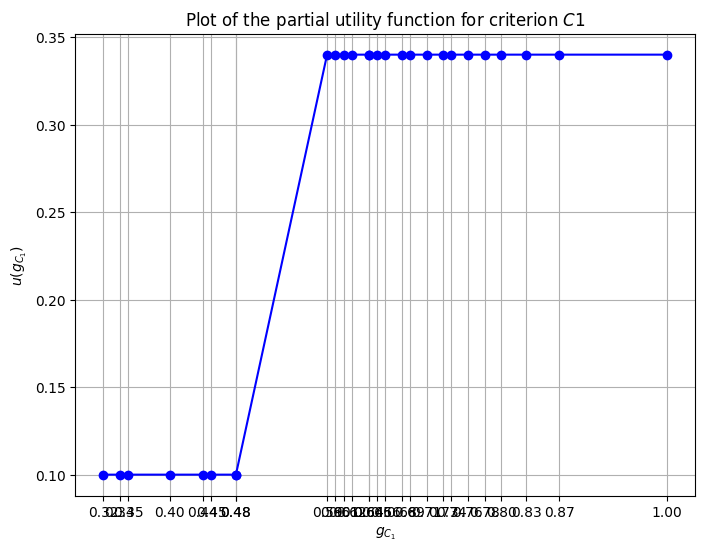

In [72]:
import matplotlib.pyplot as plt

values = data["C1"].values.tolist()
values.sort()

solver_values_C1 = [value(criterion_vars["C1"][val]) for val in values]

plt.figure(figsize=(8, 6))
plt.plot(values, solver_values_C1, marker='o', linestyle='-', color='b', label='$u(g_{C_1})$')
plt.xlabel('$g_{C_1}$')
plt.ylabel('$u(g_{C_1})$')
plt.title('Plot of the partial utility function for criterion $C1$')
plt.xticks(data["C1"].values)
plt.grid(True)
plt.show()